In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import Library

In [ ]:
import os
import gc
import PIL
import pytz
import time
import shutil
import random
import splitfolders
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from datetime import datetime,timezone
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,classification_report
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load data dan Menghapus data yang corrupt


In [ ]:
root_folder = '/content/drive/MyDrive/Orbit/Proyek Akhir/MAGNASTONE_APP/Train/Dataset'

In [ ]:
def find_filepaths(root_folder):
    filepaths = []
    for dirname, _, filenames in os.walk(root_folder):
        for filename in filenames:
            filepaths.append(os.path.join(dirname, filename))
    return filepaths

In [ ]:
def del_corrupted_images(filepaths):
    del_count = 0
    for filepath in filepaths:
        try:
            fobj = open(filepath,'rb')
            is_JFIF =  b'JFIF' in fobj.peek(10)
        finally:
            fobj.close()
        if not is_JFIF:
            del_count += 1
            os.remove(filepath)
    print(f"Total {del_count} corrupted image deleted")
    return None

In [ ]:
filepaths = find_filepaths(root_folder)
total_images_before_deletion = len(filepaths)
print(f"Total gambar sebelum dihapus = {total_images_before_deletion}")

Total gambar sebelum dihapus = 1879


In [ ]:
filepaths = find_filepaths(root_folder)
del_corrupted_images(filepaths)

Total 0 corrupted image deleted


In [ ]:
filepaths = find_filepaths(root_folder)
total_images_after_deletion = len(filepaths)
print(f"Total gambar setelah dihapus = {total_images_after_deletion}")

Total gambar setelah dihapus = 1879


## Spliting dataset into train, val and test folders

In [ ]:
input_dir = '/content/drive/MyDrive/Orbit/Proyek Akhir/MAGNASTONE_APP/Train/Dataset'
output_dir =  '/content/drive/MyDrive/Orbit/Proyek Akhir/MAGNASTONE_APP/Train/SplitDataset'

In [ ]:
splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.1,.1), group_prefix=None)

In [ ]:
print(os.listdir(output_dir))

['train', 'val', 'test']


## Loading and preparing the data
#### 1. `Load the data`
#### 2. `Resize images`
#### 3. `Normalize pixels`

In [ ]:
IMG_SHAPE = (224,224,3) # Required for MobileNetV3
train_dataset_dir = "/content/drive/MyDrive/Orbit/Proyek Akhir/MAGNASTONE_APP/Train/SplitDataset/train"
val_dataset_dir = "/content/drive/MyDrive/Orbit/Proyek Akhir/MAGNASTONE_APP/Train/SplitDataset/val"
test_dataset_dir = "/content/drive/MyDrive/Orbit/Proyek Akhir/MAGNASTONE_APP/Train/SplitDataset/test"

In [ ]:
rock_classes = os.listdir(train_dataset_dir)
filepaths = find_filepaths(train_dataset_dir)
print(f"----- Trainig Set Info -----")
print(f"Rock Classes = {rock_classes}")
print(f"Toatal rock classes = {len(rock_classes)}")
print(f"Total number of images = {len(filepaths)}")

----- Trainig Set Info -----
Rock Classes = ['Sandstone', 'Marble', 'Coal', 'Limestone', 'Quartzite', 'Granite', 'Basalt']
Toatal rock classes = 7
Total number of images = 1500


In [ ]:
rock_classes = os.listdir(val_dataset_dir)
filepaths = find_filepaths(val_dataset_dir)
print(f"----- Validation Set Info -----")
print(f"Rock Classes = {rock_classes}")
print(f"Toatal rock classes = {len(rock_classes)}")
print(f"Total number of images = {len(filepaths)}")

----- Validation Set Info -----
Rock Classes = ['Sandstone', 'Marble', 'Coal', 'Limestone', 'Quartzite', 'Granite', 'Basalt']
Toatal rock classes = 7
Total number of images = 186


In [ ]:
rock_classes = os.listdir(test_dataset_dir)
filepaths = find_filepaths(test_dataset_dir)
print(f"----- Test Set Info -----")
print(f"Rock Classes = {rock_classes}")
print(f"Toatal rock classes = {len(rock_classes)}")
print(f"Total number of images = {len(filepaths)}")

----- Test Set Info -----
Rock Classes = ['Sandstone', 'Marble', 'Coal', 'Limestone', 'Quartzite', 'Granite', 'Basalt']
Toatal rock classes = 7
Total number of images = 193


In [ ]:
def min_max_scalar(img, scale_range =(0, 1)):
    
    px_min = scale_range[0]
    px_max = scale_range[1]
    img = img.astype('float32')
    img = img/img.max()
    scaled_img = img * (px_max - px_min) + px_min
    return scaled_img

def resize(img,size):
    resized_img = img.resize(size, Image.ANTIALIAS)
    resized_img_array = np.asarray(resized_img)
    return resized_img_array

In [ ]:
def load_and_prepare_dataset(dataset_dir,IMG_SHAPE):
    
    rock_classes = os.listdir(dataset_dir)
    
    filepaths = find_filepaths(dataset_dir)
    no_of_total_images = len(filepaths)
    
    data = np.zeros((no_of_total_images,*IMG_SHAPE),dtype='float32')
    label = []
    ix = 0
    
    for class_label in rock_classes:
        class_path = os.path.join(dataset_dir, class_label)
        for img in os.listdir(class_path):
            image = Image.open(os.path.join(class_path, img))
            resized_image = resize(image,IMG_SHAPE[:-1])
            image_array = min_max_scalar(resized_image)
            if image_array.shape == IMG_SHAPE:
                data[ix]=image_array
                label.append(class_label)
            else:
                image_array=np.stack((image_array,)*3, axis=-1)
                data[ix]=image_array
                label.append(class_label)
            ix += 1
    label = np.asarray(label)
    label = label.reshape((-1,1))
        
    return data,label

In [ ]:
X_train,y_train = load_and_prepare_dataset(train_dataset_dir,IMG_SHAPE)
X_val,y_val = load_and_prepare_dataset(val_dataset_dir,IMG_SHAPE)
X_test,y_test = load_and_prepare_dataset(test_dataset_dir,IMG_SHAPE)

In [ ]:
print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of X_val = {X_val.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (1500, 224, 224, 3)
Shape of y_train = (1500, 1)
Shape of X_val = (186, 224, 224, 3)
Shape of y_val = (186, 1)
Shape of X_test = (193, 224, 224, 3)
Shape of y_test = (193, 1)


## Visualizing the rock classes

In [ ]:
def show_unique_images(X,y,idx=0):
    y = np.squeeze(y)
    unique = np.unique(y)
    index=[]
    for i in unique:
        try:
            r = np.where(y==i)
            index.append (r[0][idx])
        except:
            pass
    
    images=[]
    labels=[]
    for i in index:
        images.append(X[i])
        labels.append(y[i])
    
    plt.figure(figsize=(16,9))
    
    for i in range(np.unique(y).size):
        ax = plt.subplot(1,7, i+1)
        
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")
        
    return None


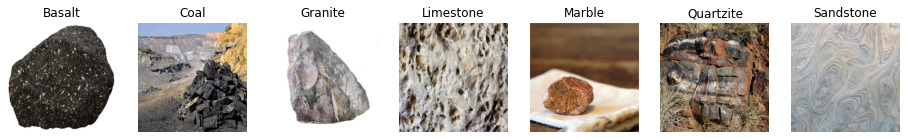

In [ ]:
show_unique_images(X_test,y_test)

## Class distribution sebelum smote

In [ ]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values =Counter(np.squeeze(y_train).tolist()).values()
rock_count_per_class_before_smote = dict(zip(classes,values))
print(rock_count_per_class_before_smote)

{'Sandstone': 256, 'Marble': 307, 'Coal': 283, 'Limestone': 216, 'Quartzite': 378, 'Granite': 28, 'Basalt': 32}


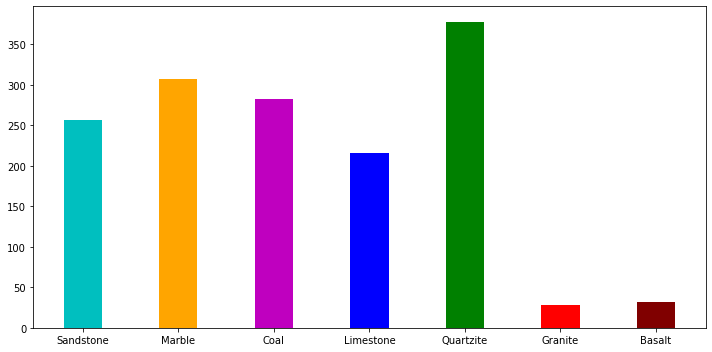

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
rock_names = list(rock_count_per_class_before_smote.keys())
rock_counts = list(rock_count_per_class_before_smote.values())
plt.bar(rock_names,rock_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()  

## Menerapkan SMOTE untuk menghilangkan data imbalance

In [ ]:
# Reshaping is important for feeding the data into fit_resample method of SMOTE class
X_train = X_train.reshape((-1,IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]))
print(f"Shape of data is {X_train.shape}")
print(f"Shape of label is {y_train.shape}")
print(f"Data type of data is {type(X_train)}")
print(f"Data type of label is {type(y_train)}")

Shape of data is (1500, 150528)
Shape of label is (1500, 1)
Data type of data is <class 'numpy.ndarray'>
Data type of label is <class 'numpy.ndarray'>


In [ ]:
smote = SMOTE(random_state=42)
X_train = X_train.reshape((-1,IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]))
X_train, y_train = smote.fit_resample(X_train,y_train)

In [ ]:
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")

Shape of X_train : (2646, 150528)
Shape of y_train : (2646,)


In [ ]:
X_train = X_train.reshape((-1,*IMG_SHAPE))
y_train = y_train.reshape((-1,1))
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")

Shape of X_train : (2646, 224, 224, 3)
Shape of y_train : (2646, 1)


## Class distribution setelah smote

In [ ]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values =Counter(np.squeeze(y_train).tolist()).values()
rock_count_per_class_after_smote = dict(zip(classes,values))
print(rock_count_per_class_after_smote)

{'Sandstone': 378, 'Marble': 378, 'Coal': 378, 'Limestone': 378, 'Quartzite': 378, 'Granite': 378, 'Basalt': 378}


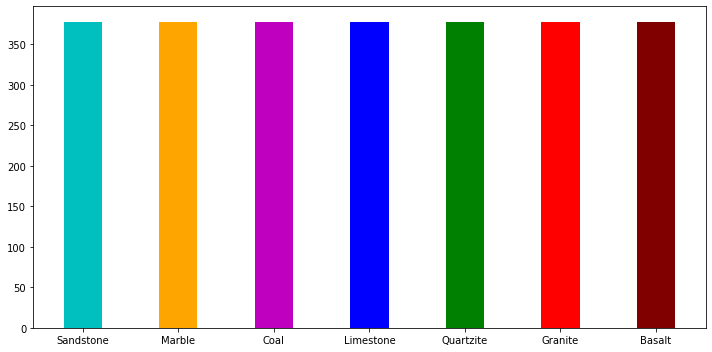

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
rock_names = list(rock_count_per_class_after_smote.keys())
rock_counts = list(rock_count_per_class_after_smote.values())
plt.bar(rock_names,rock_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()  

#Pre-Processing Dataset

In [ ]:
# One hot encoding
def one_hot_encoder(array):
    encoded_array = []
    unique = np.unique(array)
    for item in array:
        encoded_item = item == unique
        encoded_array.append(encoded_item)
    encoded_array = np.asarray(encoded_array)
    encoded_array = encoded_array.astype(int)
    return encoded_array

In [ ]:
y_train_encoded = one_hot_encoder(y_train)
y_val_encoded = one_hot_encoder(y_val)
y_test_encoded = one_hot_encoder(y_test)

In [ ]:
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of y_train_encoded = {y_train_encoded.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of y_val_encoded = {y_val_encoded.shape}")
print(f"Shape of y_test = {y_test.shape}")
print(f"Shape of y_test_encoded = {y_test_encoded.shape}")

Shape of y_train = (2646, 1)
Shape of y_train_encoded = (2646, 7)
Shape of y_val = (186, 1)
Shape of y_val_encoded = (186, 7)
Shape of y_test = (193, 1)
Shape of y_test_encoded = (193, 7)


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l1_l2

In [ ]:
BaseModel = MobileNet(weights='imagenet', include_top=False, input_shape= IMG_SHAPE )

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
output_size = len(y_train_encoded[0])
print(f"Output Size = {output_size}")

Output Size = 7


#Arsitektur 1

In [ ]:
model = Sequential()

model.add(BaseModel)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu',
                kernel_regularizer=l1_l2(0.01),
                bias_regularizer=l1_l2(0.01)))

model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(output_size, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 batch_normalization (BatchN  (None, 94080)            376320    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               24084736  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(learning_rate=0.001),
              metrics=['accuracy']) 

#Arsitektur 2

In [ ]:
model = Sequential()

model.add(BaseModel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(7, activation="softmax" , name="classification"))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0004,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 7)                

In [ ]:
# Check if all the shapes are ok 
print(X_train.shape[0]==y_train_encoded.shape[0])
print(type(X_train) == type(y_train_encoded))
print(X_train.shape)
print(y_train_encoded.shape)
print(X_val.shape)
print(y_val_encoded.shape)

True
True
(2646, 224, 224, 3)
(2646, 7)
(186, 224, 224, 3)
(186, 7)


#Train and Test

In [ ]:
history = model.fit(X_train,y_train_encoded, 
                    validation_data=(X_val,y_val_encoded),
                    batch_size=32, epochs=30)

Epoch 1/30
83/83 [==============================] - 28s 200ms/step - loss: 1.4278 - accuracy: 0.4909 - val_loss: 1.2373 - val_accuracy: 0.5645
Epoch 2/30
83/83 [==============================] - 15s 180ms/step - loss: 0.6901 - accuracy: 0.7865 - val_loss: 0.8330 - val_accuracy: 0.7312
Epoch 3/30
83/83 [==============================] - 15s 181ms/step - loss: 0.4547 - accuracy: 0.8522 - val_loss: 0.7945 - val_accuracy: 0.7312
Epoch 4/30
83/83 [==============================] - 15s 185ms/step - loss: 0.3459 - accuracy: 0.8949 - val_loss: 0.7161 - val_accuracy: 0.7581
Epoch 5/30
83/83 [==============================] - 15s 184ms/step - loss: 0.2782 - accuracy: 0.9195 - val_loss: 0.7288 - val_accuracy: 0.7312
Epoch 6/30
83/83 [==============================] - 15s 185ms/step - loss: 0.2343 - accuracy: 0.9361 - val_loss: 0.6702 - val_accuracy: 0.7581
Epoch 7/30
83/83 [==============================] - 15s 184ms/step - loss: 0.1949 - accuracy: 0.9505 - val_loss: 0.6403 - val_accuracy: 0.7742

In [ ]:
def plot_accuracy_loss(history):
    f,ax = plt.subplots(1,2,figsize=(12,6))
    
    ax[0].plot([None]+history.history['accuracy'],'o-')
    ax[0].plot([None]+history.history['val_accuracy'],'o-')
    ax[0].legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax[0].set_title('Training & Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot([None]+history.history['loss'],'o-')
    ax[1].plot([None]+history.history['val_loss'],'o-')
    ax[1].legend(['Training Loss','Validation Loss'],loc = 0)
    ax[1].set_title('Training & Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()
    
    return None


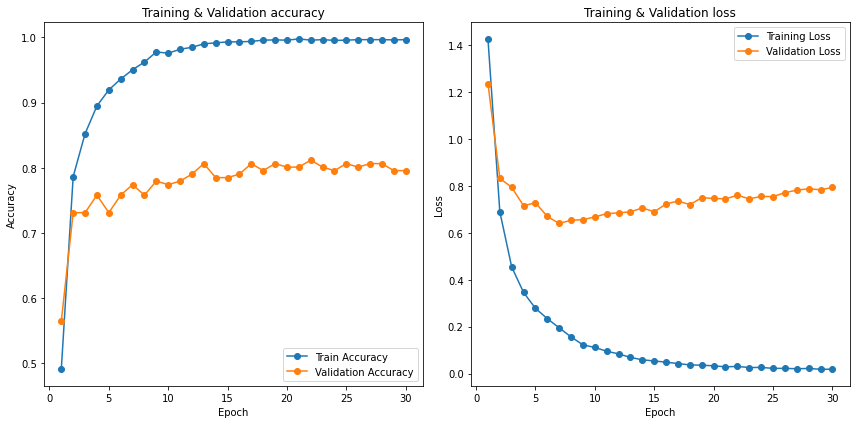

In [ ]:
plot_accuracy_loss(history)

## Evaluate Model's performance

In [ ]:
result = model.evaluate(X_test,y_test_encoded)
print(result)

7/7 [==============================] - 0s 70ms/step - loss: 0.7544 - accuracy: 0.7927
[0.7543935775756836, 0.7927461266517639]


In [ ]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print(predictions)

7/7 [==============================] - 1s 33ms/step
[6 6 3 6 6 3 3 6 6 6 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 5 5 4 4
 4 1 5 4 6 5 6 4 4 1 1 4 5 4 4 5 4 4 4 4 4 4 4 5 4 4 4 4 5 4 4 5 1 4 4 1 1
 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 4 3 3
 5 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 4 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 4 5 3 5 3
 2 3 3 2 6 3 4 1]


In [ ]:
def label_encoder(string):
    rock_classes = ['Basalt','Coal', 'Granite','Limestone','Marble','Quartzite', 'Sandstone']
    for i,rock in enumerate(rock_classes):
        if string == rock:
            return i
y_test_enc = np.asarray(list(map(label_encoder,np.squeeze(y_test).tolist())))
print(y_test_enc)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2
 2 2 2 0 0 0 0 0]


In [ ]:
print(classification_report(y_test_enc,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.85      0.92      0.88        36
           2       0.50      0.20      0.29         5
           3       0.73      0.89      0.80        27
           4       0.77      0.62      0.69        39
           5       0.75      0.90      0.82        48
           6       0.90      0.85      0.88        33

    accuracy                           0.79       193
   macro avg       0.64      0.62      0.62       193
weighted avg       0.77      0.79      0.78       193



In [ ]:
def display_confusion_matrix(confusion_matrix,labels):
    conf_matrix_df = pd.DataFrame(confusion_matrix,
                         index = labels,
                         columns = labels)
    plt.figure(figsize=(15,6))
    sns.heatmap(conf_matrix_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return None

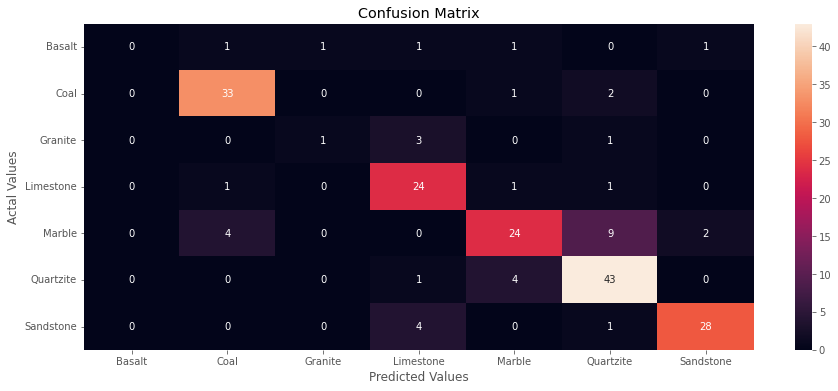

In [ ]:
labels = ['Basalt','Coal', 'Granite','Limestone','Marble','Quartzite', 'Sandstone']
conf_matrix = confusion_matrix(y_test_enc,predictions)
display_confusion_matrix(conf_matrix,labels)

## Save and Load Model

In [ ]:
from tensorflow.keras.models import load_model
# Save the weights
model.save('/content/drive/MyDrive/Orbit/Proyek Akhir/MAGNASTONE_APP/Train/saved_model/MobileNet-SGD_79Model.h5')

#Model Predict

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
image = load_img('/content/drive/MyDrive/Orbit/coal.jpg', target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)

In [ ]:
# Prediksi untuk Data Latih
y_pred_train            = model.predict(img)
y_pred_train_classes    = np.argmax(y_pred_train)
y_pred_train_max_probas = np.max(y_pred_train)

1/1 [==============================] - 0s 18ms/step


In [ ]:
print(y_pred_train)
print(y_pred_train_classes)
print(y_pred_train_max_probas)

[[1.5306252e-03 9.9806935e-01 1.2080422e-05 3.3621836e-04 2.7436645e-05
  1.5506199e-05 8.8055313e-06]]
1
0.99806935
